In [9]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import density_functions as dens
import lmcgeometry as lgeo
import mlefitting as mle
import olsfitting as ols
import utilities as util

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

# progress bar
from tqdm import tqdm_notebook

# statsmodels 
import statsmodels.api as sm

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

<font size='20'>
    <b>
        Data
    </b>
</font>

In [2]:
###################
### Import Data ###
###################

#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-9999.0)&(r13['LOGG']>0.0)&\
                (r13['M_H_ERR']>-90.0)&(r13['C_FE']>-9999.0)&(r13['N_FE']>-9999.0))

r13 = r13[clnr]

#Transform APOGEE RA and DEC to Magellanic Stream L and B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

<font size='20'>
    <b>
        Initial Setup Stuff
    </b>
</font>

In [3]:
##############
### Fields ###
##############

field_str = ['30Dor','LMC1','LMC2','LMC3','LMC4','LMC5','LMC6','LMC7','LMC8','LMC9','LMC10','LMC11','LMC12',
             'LMC13','LMC14','LMC15','LMC16','LMC17']

In [4]:
#####################
### blue loop cut ###
#####################

bloop = np.where((r13['TEFF']>=4100)&(r13['H']<=13.0)&((r13['J']-r13['K'])<=0.95))

bloop_cut = []
for i in range(len(r13)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
bloopr13 = r13[bloop_cut]

fields = []
for i in range(len(field_str)):
    fields.append(np.where(bloopr13['FIELD']==field_str[i]))

<font size='20'>
    <b>
        Ages
    </b>
</font>

In [5]:
####################
### PCA OLS Ages ###
####################
ages = fits.getdata('../LMC_Ages/pca_ols_ages.fits')

#####################
### Make Age Bins ###
#####################

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

r13young = r13[young]
r13yless = r13[yless]
r13ymed = r13[ymed]
r13omed = r13[omed]
r13old = r13[old]

In [6]:
xLMC, yLMC, stardist = lgeo.LMCdisk_cart(r13['RA'],r13['DEC'])
ell_over = lgeo.elliptical_radius(xLMC,yLMC)
bloopage = np.asarray(ages['AGE'])[bloop_cut]
bloopabsH = (astro.absmag(r13['H'],stardist)-r13['AK_TARG'])[bloop_cut]

<font size='20'>
    <b>
        Density Calculation
    </b>
</font>

## Area Calculations

In [7]:
############
### pc^2 ###
############

field_ang = [0.8,0.95,0.95,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.95,0.8,0.8,0.8,0.95,0.8]
field_areas = np.multiply(np.pi*np.square(np.multiply(field_ang,0.875)),10**6)

## Field Mass

In [8]:
iso_ages = []
iso_zs = []

#fnt and brt bins
fbins = dens.brtfntlmc_bins(bloopr13)

for i in range(len(field_str)):
    fd = np.where(bloopr13['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(bloopage[fd]),np.median(bloopr13[fd]['FE_H']))
    iso_ages.append(age)
    iso_zs.append(z)

absHs = []
for i in range(len(field_str)):
    field_H = np.where(bloopr13['FIELD']==field_str[i]) 
    absHs.append(np.asarray(bloopabsH)[field_H])

sf_brites = []
sf_faints = []

for i in field_str:
    fld = np.where(bloopr13['FIELD']==i)
    
    fnts = np.where(bloopr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(bloopr13['TARGET_NAME'][fld]=='BrtRGB')
    
    sf_faints.append(bloopr13['SELECTFUNC'][fld][fnts])
    sf_brites.append(bloopr13['SELECTFUNC'][fld][brts])

field_masses = []
for i in range(len(field_str)):
    field_masses.append(dens.fieldmass(iso_ages[i],iso_zs[i],absHs[i],sf_brites[i],sf_faints[i],parsec))
print(field_masses)

[37279100.50485136, 3850403.2122854977, 2718359.802415756, 15959568.884118618, 100809566.58846523, 67569762.38550797, 44371470.280949324, 15590385.001112849, 57524785.56403179, 291589696.7055777, 10808223.390080359, 29753601.826820552, 2142708.324760281, 54782321.05147686, 80387812.38569418, 14011911.921773989, 2995113.3263788, 15827307.196528194]


## 30 Dor rm

In [10]:
### Calculate Surface Densities and Density Profile

import statsmodels.api as sm

surfden = []
for i in range(len(field_masses)):
    surfden.append(np.divide(field_masses[i],field_areas[i]))
    
'''
model is sigma = A*exp(B*r)
A central density 
B radial scale height 
r radius

ln(sigma) = lnA + B*r
''' 

field_list = [np.where(bloopr13['FIELD']=='30Dor'),np.where(bloopr13['FIELD']=='LMC1'),
              np.where(bloopr13['FIELD']=='LMC2'),np.where(bloopr13['FIELD']=='LMC3'),
              np.where(bloopr13['FIELD']=='LMC4'),np.where(bloopr13['FIELD']=='LMC5'),
              np.where(bloopr13['FIELD']=='LMC6'),np.where(bloopr13['FIELD']=='LMC7'),
              np.where(bloopr13['FIELD']=='LMC8'),np.where(bloopr13['FIELD']=='LMC9'),
              np.where(bloopr13['FIELD']=='LMC10'),np.where(bloopr13['FIELD']=='LMC11'),
              np.where(bloopr13['FIELD']=='LMC12'),np.where(bloopr13['FIELD']=='LMC13'),
              np.where(bloopr13['FIELD']=='LMC14'),np.where(bloopr13['FIELD']=='LMC15'),
              np.where(bloopr13['FIELD']=='LMC16'),np.where(bloopr13['FIELD']=='LMC17')]

radii = []
for i in range(len(field_str)):
    radii.append(np.median(ell_over[field_list[i]]))

1.3389744978885696 +/- 0.3396230699611299


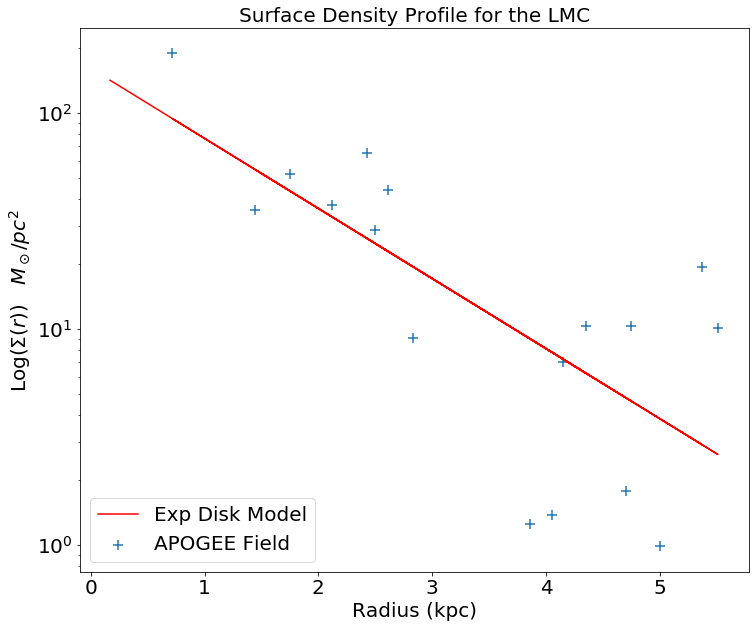

In [12]:
radii_rm30dor = np.delete(radii,0)
surfden_rm30dor = np.delete(surfden,0)

p, err = ols.ols_fit(radii_rm30dor,np.log(surfden_rm30dor))
print(str(-1./p[0])+ ' +/- ' + str(err[0]/(p[0]**2)))

def lmcdensityprofile_rm30dor(r):
    return p[1]+np.multiply(p[0],r)

plt.figure(figsize=[12,10])

plt.scatter(radii_rm30dor,surfden_rm30dor,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)

plt.plot(radii,np.exp(lmcdensityprofile_rm30dor(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile_rm30dor.pdf',bbox_inches='tight')
plt.show()

# Metallicity Bins

In [13]:
metal_poor = np.where(bloopr13['FE_H']<-0.87833154)
m_int1 = np.where((bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
m_int2 = np.where((bloopr13['FE_H']>=-0.7067915)&(bloopr13['FE_H']<-0.5933316))
metal_rich = np.where(bloopr13['FE_H']>=-0.5933316)

#Metal Poor
mpr13 = bloopr13[metal_poor]
mpages = bloopage[metal_poor]
mpabsH = bloopabsH[metal_poor]

#Metal Intermediate 1
mint1r13 = bloopr13[m_int1]
mint1ages = bloopage[m_int1]
mint1absH = bloopabsH[m_int1]

#Metal Intermediate 2
mint2r13 = bloopr13[m_int2]
mint2ages = bloopage[m_int2]
mint2absH = bloopabsH[m_int2]

#Metal Rich
mrr13 = bloopr13[metal_rich]
mrages = bloopage[metal_rich]
mrabsH = bloopabsH[metal_rich]

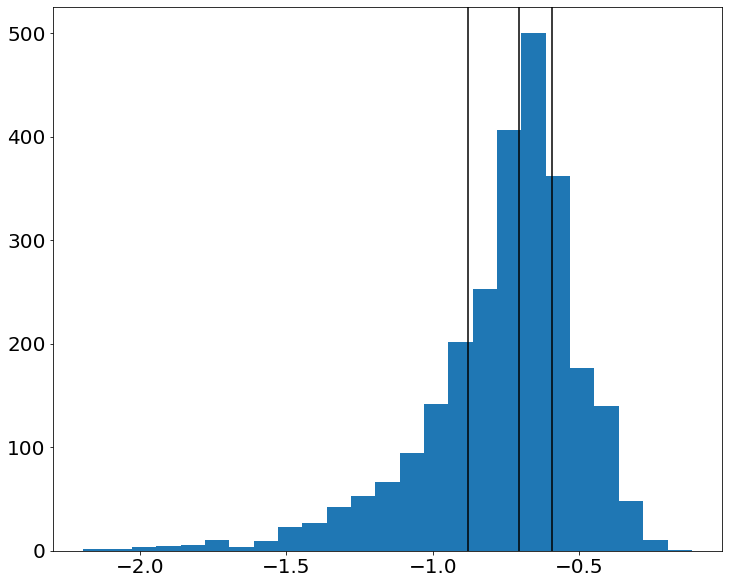

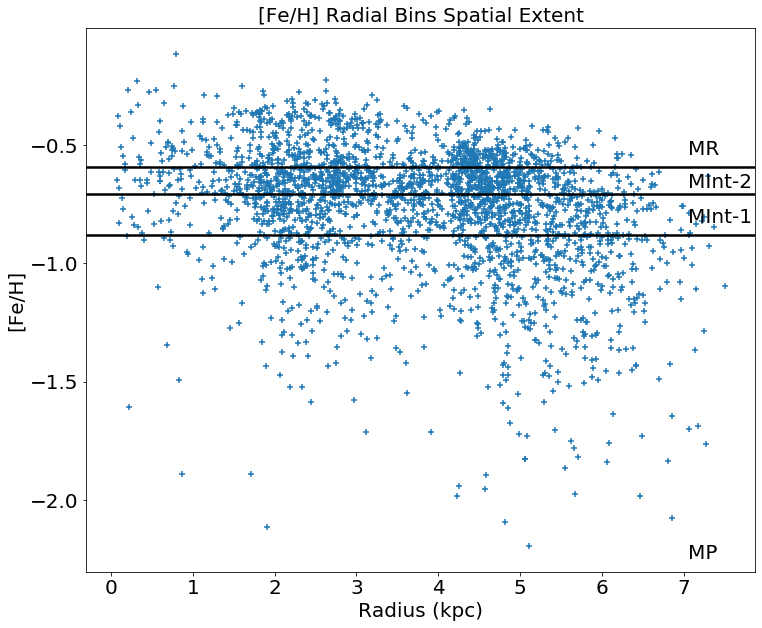

In [14]:
## Metallicity histogram with bins
plt.figure(figsize=[12,10])
plt.hist(r13['FE_H'],bins=25)
plt.axvline(-0.87833154,c='k')
plt.axvline(-0.7067915,c='k')
plt.axvline(-0.5933316,c='k')
plt.show()

## Metallicity as function of radius
plt.figure(figsize=[12,10])
plt.scatter(np.sqrt(xLMC**2+yLMC**2),r13['FE_H'],marker='+',c='tab:blue')
plt.axhline(-0.87833154,c='k',lw=2.5)
plt.axhline(-0.7067915,c='k',lw=2.5)
plt.axhline(-0.5933316,c='k',lw=2.5)

plt.title(r'[Fe/H] Radial Bins Spatial Extent',fontsize=20)

plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'[Fe/H]',fontsize=20)

plt.text(7.05,-0.5933316+0.05,'MR',fontsize=20)
plt.text(7.05,-0.7067915+0.025,'MInt-2',fontsize=20)
plt.text(7.05,-0.87833154+0.05,'MInt-1',fontsize=20)
plt.text(7.05,-2.25,'MP',fontsize=20)
plt.show()

### Metal Poor (MP)

In [38]:
mp_iso_ages = []
mp_iso_zs = []

#fnt and brt bins
mp_fbins = dens.brtfntlmc_bins(mpr13)

for i in range(len(field_str)):
    fd = np.where(mpr13['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(mpages[fd]),np.median(mpr13[fd]['FE_H']))
    mp_iso_ages.append(age)
    mp_iso_zs.append(z)

mp_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mpr13['FIELD']==field_str[i]) 
    mp_absHs.append(np.asarray(mpabsH)[field_H])

mp_sf_brites = []
mp_sf_faints = []

for i in field_str:
    fld = np.where(mpr13['FIELD']==i)
    
    fnts = np.where(mpr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mpr13['TARGET_NAME'][fld]=='BrtRGB')
    
    mp_sf_faints.append(mpr13['SELECTFUNC'][fld][fnts])
    mp_sf_brites.append(mpr13['SELECTFUNC'][fld][brts])
        
mp_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mp_field_masses.append(dens.fieldmass(mp_iso_ages[i],mp_iso_zs[i],mp_absHs[i],mp_sf_brites[i],
                                               mp_sf_faints[i],parsec))
    except:
        mp_field_masses.append(-9999.0)
        
for i in range(len(mp_field_masses)):
    if np.isfinite(mp_field_masses[i]) == False:
        mp_field_masses[i] = -9999.0

1.499464608296635 +/- 0.42591703606659365


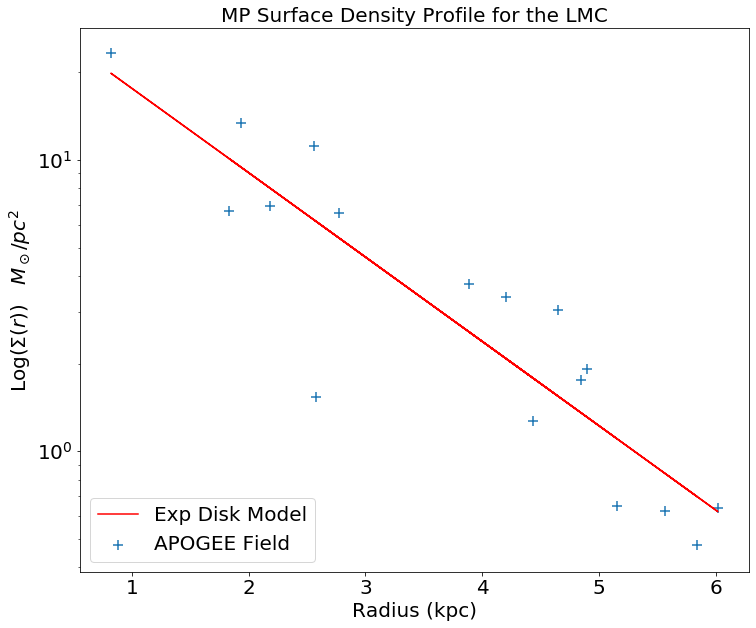

In [54]:
mp_surfden = []
for i in range(len(mp_field_masses)):
    mp_surfden.append(np.divide(mp_field_masses[i],field_areas[i]))

mp_field_list = [np.where(mpr13['FIELD']=='30Dor'),np.where(mpr13['FIELD']=='LMC1'),
              np.where(mpr13['FIELD']=='LMC2'),np.where(mpr13['FIELD']=='LMC3'),
              np.where(mpr13['FIELD']=='LMC4'),np.where(mpr13['FIELD']=='LMC5'),
              np.where(mpr13['FIELD']=='LMC6'),np.where(mpr13['FIELD']=='LMC7'),
              np.where(mpr13['FIELD']=='LMC8'),np.where(mpr13['FIELD']=='LMC9'),
              np.where(mpr13['FIELD']=='LMC10'),np.where(mpr13['FIELD']=='LMC11'),
              np.where(mpr13['FIELD']=='LMC12'),np.where(mpr13['FIELD']=='LMC13'),
              np.where(mpr13['FIELD']=='LMC14'),np.where(mpr13['FIELD']=='LMC15'),
              np.where(mpr13['FIELD']=='LMC16'),np.where(mpr13['FIELD']=='LMC17')]

mp_radii = []

x_mp, y_mp, _ = lgeo.LMCdisk_cart(mpr13['RA'],mpr13['DEC'])
ell_mp = lgeo.elliptical_radius(x_mp,y_mp)
for i in range(len(field_str)):
    
    mp_radii.append(np.median(ell_mp[mp_field_list[i]]))
    
# remove negative values
good = np.where(np.asarray(mp_surfden)>0.0)
mp_radii = np.asarray(mp_radii)[good]
mp_surfden = np.asarray(mp_surfden)[good]

mp_p,mp_err = ols.ols_fit(mp_radii,np.log(mp_surfden))
print(str(-1./mp_p[0])+ ' +/- ' + str(err[0]/(mp_p[0]**2)))

def mpprofile(r):
    return mp_p[1]+np.multiply(mp_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mp_radii,mp_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('MP Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mpprofile.pdf',bbox_inches='tight')
plt.show()

### Metal Intermediate 1 (Mint1)

In [57]:
mint1_iso_ages = []
mint1_iso_zs = []

#fnt and brt bins
mint1_fbins = dens.brtfntlmc_bins(mint1r13)

for i in range(len(field_str)):
    fd = np.where(mint1r13['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(mint1ages[fd]),np.median(mint1r13[fd]['FE_H']))
    mint1_iso_ages.append(age)
    mint1_iso_zs.append(z)

mint1_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mint1r13['FIELD']==field_str[i]) 
    mint1_absHs.append(np.asarray(mint1absH)[field_H])

mint1_sf_brites = []
mint1_sf_faints = []

for i in field_str:
    fld = np.where(mint1r13['FIELD']==i)
    
    fnts = np.where(mint1r13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mint1r13['TARGET_NAME'][fld]=='BrtRGB')
    
    mint1_sf_faints.append(mint1r13['SELECTFUNC'][fld][fnts])
    mint1_sf_brites.append(mint1r13['SELECTFUNC'][fld][brts])
        
mint1_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mint1_field_masses.append(dens.fieldmass(mint1_iso_ages[i],mint1_iso_zs[i],mint1_absHs[i],mint1_sf_brites[i],
                                               mint1_sf_faints[i],parsec))
    except:
        mint1_field_masses.append(-9999.0)
        
for i in range(len(mint1_field_masses)):
    if np.isfinite(mint1_field_masses[i]) == False:
        mint1_field_masses[i] = -9999.0

1.128013565336356 +/- 0.24103561463077292


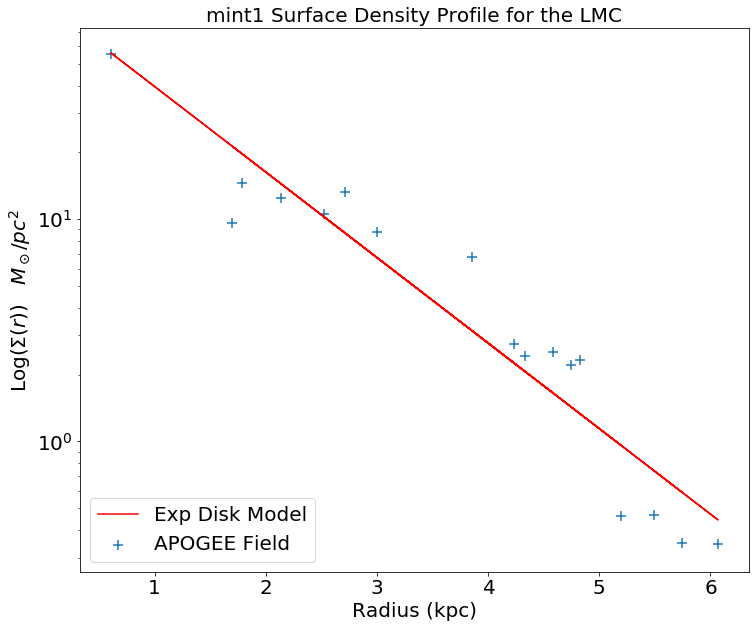

In [59]:
mint1_surfden = []
for i in range(len(mint1_field_masses)):
    mint1_surfden.append(np.divide(mint1_field_masses[i],field_areas[i]))

mint1_field_list = [np.where(mint1r13['FIELD']=='30Dor'),np.where(mint1r13['FIELD']=='LMC1'),
              np.where(mint1r13['FIELD']=='LMC2'),np.where(mint1r13['FIELD']=='LMC3'),
              np.where(mint1r13['FIELD']=='LMC4'),np.where(mint1r13['FIELD']=='LMC5'),
              np.where(mint1r13['FIELD']=='LMC6'),np.where(mint1r13['FIELD']=='LMC7'),
              np.where(mint1r13['FIELD']=='LMC8'),np.where(mint1r13['FIELD']=='LMC9'),
              np.where(mint1r13['FIELD']=='LMC10'),np.where(mint1r13['FIELD']=='LMC11'),
              np.where(mint1r13['FIELD']=='LMC12'),np.where(mint1r13['FIELD']=='LMC13'),
              np.where(mint1r13['FIELD']=='LMC14'),np.where(mint1r13['FIELD']=='LMC15'),
              np.where(mint1r13['FIELD']=='LMC16'),np.where(mint1r13['FIELD']=='LMC17')]

mint1_radii = []

x_mint1, y_mint1, _ = lgeo.LMCdisk_cart(mint1r13['RA'],mint1r13['DEC'])
ell_mint1 = lgeo.elliptical_radius(x_mint1,y_mint1)
for i in range(len(field_str)):
    
    mint1_radii.append(np.median(ell_mint1[mint1_field_list[i]]))
    
# remove negative values
good = np.where(np.asarray(mint1_surfden)>0.0)
mint1_radii = np.asarray(mint1_radii)[good]
mint1_surfden = np.asarray(mint1_surfden)[good]

# rm 30 Dor
mint1_radii = np.delete(mint1_radii,0)
mint1_surfden = np.delete(mint1_surfden,0)

mint1_p,mint1_err = ols.ols_fit(mint1_radii,np.log(mint1_surfden))
print(str(-1./mint1_p[0])+ ' +/- ' + str(err[0]/(mint1_p[0]**2)))

def mint1profile(r):
    return mint1_p[1]+np.multiply(mint1_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mint1_radii,mint1_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mint1_radii,np.exp(mint1profile(mint1_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('mint1 Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mint1profile.pdf',bbox_inches='tight')
plt.show()

### Metal Intermediate 2 (Mint2)

In [60]:
mint2_iso_ages = []
mint2_iso_zs = []

#fnt and brt bins
mint2_fbins = dens.brtfntlmc_bins(mint2r13)

for i in range(len(field_str)):
    fd = np.where(mint2r13['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(mint2ages[fd]),np.median(mint2r13[fd]['FE_H']))
    mint2_iso_ages.append(age)
    mint2_iso_zs.append(z)

mint2_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mint2r13['FIELD']==field_str[i]) 
    mint2_absHs.append(np.asarray(mint2absH)[field_H])

mint2_sf_brites = []
mint2_sf_faints = []

for i in field_str:
    fld = np.where(mint2r13['FIELD']==i)
    
    fnts = np.where(mint2r13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mint2r13['TARGET_NAME'][fld]=='BrtRGB')
    
    mint2_sf_faints.append(mint2r13['SELECTFUNC'][fld][fnts])
    mint2_sf_brites.append(mint2r13['SELECTFUNC'][fld][brts])
        
mint2_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mint2_field_masses.append(dens.fieldmass(mint2_iso_ages[i],mint2_iso_zs[i],mint2_absHs[i],mint2_sf_brites[i],
                                               mint2_sf_faints[i],parsec))
    except:
        mint2_field_masses.append(-9999.0)
        
for i in range(len(mint2_field_masses)):
    if np.isfinite(mint2_field_masses[i]) == False:
        mint2_field_masses[i] = -9999.0

1.228082607909836 +/- 0.28569835133271765


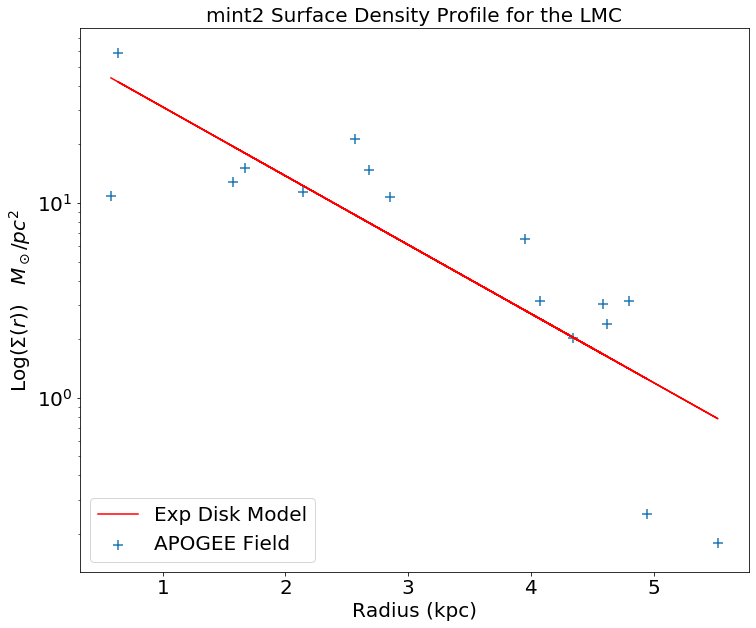

In [61]:
mint2_surfden = []
for i in range(len(mint2_field_masses)):
    mint2_surfden.append(np.divide(mint2_field_masses[i],field_areas[i]))

mint2_field_list = [np.where(mint2r13['FIELD']=='30Dor'),np.where(mint2r13['FIELD']=='LMC1'),
              np.where(mint2r13['FIELD']=='LMC2'),np.where(mint2r13['FIELD']=='LMC3'),
              np.where(mint2r13['FIELD']=='LMC4'),np.where(mint2r13['FIELD']=='LMC5'),
              np.where(mint2r13['FIELD']=='LMC6'),np.where(mint2r13['FIELD']=='LMC7'),
              np.where(mint2r13['FIELD']=='LMC8'),np.where(mint2r13['FIELD']=='LMC9'),
              np.where(mint2r13['FIELD']=='LMC10'),np.where(mint2r13['FIELD']=='LMC11'),
              np.where(mint2r13['FIELD']=='LMC12'),np.where(mint2r13['FIELD']=='LMC13'),
              np.where(mint2r13['FIELD']=='LMC14'),np.where(mint2r13['FIELD']=='LMC15'),
              np.where(mint2r13['FIELD']=='LMC16'),np.where(mint2r13['FIELD']=='LMC17')]

mint2_radii = []

x_mint2, y_mint2, _ = lgeo.LMCdisk_cart(mint2r13['RA'],mint2r13['DEC'])
ell_mint2 = lgeo.elliptical_radius(x_mint2,y_mint2)
for i in range(len(field_str)):
    
    mint2_radii.append(np.median(ell_mint2[mint2_field_list[i]]))
    
# remove negative values
good = np.where(np.asarray(mint2_surfden)>0.0)
mint2_radii = np.asarray(mint2_radii)[good]
mint2_surfden = np.asarray(mint2_surfden)[good]

mint2_p,mint2_err = ols.ols_fit(mint2_radii,np.log(mint2_surfden))
print(str(-1./mint2_p[0])+ ' +/- ' + str(err[0]/(mint2_p[0]**2)))

def mint2profile(r):
    return mint2_p[1]+np.multiply(mint2_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mint2_radii,mint2_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mint2_radii,np.exp(mint2profile(mint2_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('mint2 Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mint2profile.pdf',bbox_inches='tight')
plt.show()

### Metal Rich (MR)

In [64]:
mr_iso_ages = []
mr_iso_zs = []

#fnt and brt bins
mr_fbins = dens.brtfntlmc_bins(mrr13)

for i in range(len(field_str)):
    fd = np.where(mrr13['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(mrages[fd]),np.median(mrr13[fd]['FE_H']))
    mr_iso_ages.append(age)
    mr_iso_zs.append(z)

mr_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mrr13['FIELD']==field_str[i]) 
    mr_absHs.append(np.asarray(mrabsH)[field_H])

mr_sf_brites = []
mr_sf_faints = []

for i in field_str:
    fld = np.where(mrr13['FIELD']==i)
    
    fnts = np.where(mrr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mrr13['TARGET_NAME'][fld]=='BrtRGB')
    
    mr_sf_faints.append(mrr13['SELECTFUNC'][fld][fnts])
    mr_sf_brites.append(mrr13['SELECTFUNC'][fld][brts])
        
mr_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mr_field_masses.append(dens.fieldmass(mr_iso_ages[i],mr_iso_zs[i],mr_absHs[i],mr_sf_brites[i],
                                               mr_sf_faints[i],parsec))
    except:
        mr_field_masses.append(-9999.0)
        
for i in range(len(mr_field_masses)):
    if np.isfinite(mr_field_masses[i]) == False:
        mr_field_masses[i] = -9999.0

1.1977738216133091 +/- 0.2717704329816025


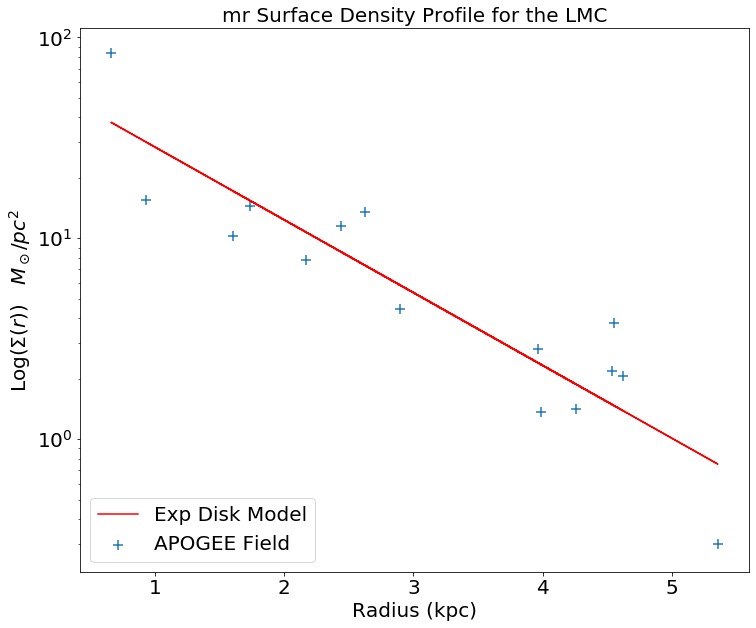

In [65]:
mr_surfden = []
for i in range(len(mr_field_masses)):
    mr_surfden.append(np.divide(mr_field_masses[i],field_areas[i]))

mr_field_list = [np.where(mrr13['FIELD']=='30Dor'),np.where(mrr13['FIELD']=='LMC1'),
              np.where(mrr13['FIELD']=='LMC2'),np.where(mrr13['FIELD']=='LMC3'),
              np.where(mrr13['FIELD']=='LMC4'),np.where(mrr13['FIELD']=='LMC5'),
              np.where(mrr13['FIELD']=='LMC6'),np.where(mrr13['FIELD']=='LMC7'),
              np.where(mrr13['FIELD']=='LMC8'),np.where(mrr13['FIELD']=='LMC9'),
              np.where(mrr13['FIELD']=='LMC10'),np.where(mrr13['FIELD']=='LMC11'),
              np.where(mrr13['FIELD']=='LMC12'),np.where(mrr13['FIELD']=='LMC13'),
              np.where(mrr13['FIELD']=='LMC14'),np.where(mrr13['FIELD']=='LMC15'),
              np.where(mrr13['FIELD']=='LMC16'),np.where(mrr13['FIELD']=='LMC17')]

mr_radii = []

x_mr, y_mr, _ = lgeo.LMCdisk_cart(mrr13['RA'],mrr13['DEC'])
ell_mr = lgeo.elliptical_radius(x_mr,y_mr)
for i in range(len(field_str)):
    
    mr_radii.append(np.median(ell_mr[mr_field_list[i]]))
    
# remove negative values
good = np.where(np.asarray(mr_surfden)>0.0)
mr_radii = np.asarray(mr_radii)[good]
mr_surfden = np.asarray(mr_surfden)[good]

mr_p,mr_err = ols.ols_fit(mr_radii,np.log(mr_surfden))
print(str(-1./mr_p[0])+ ' +/- ' + str(err[0]/(mr_p[0]**2)))

def mrprofile(r):
    return mr_p[1]+np.multiply(mr_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mr_radii,mr_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('mr Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mrprofile.pdf',bbox_inches='tight')
plt.show()

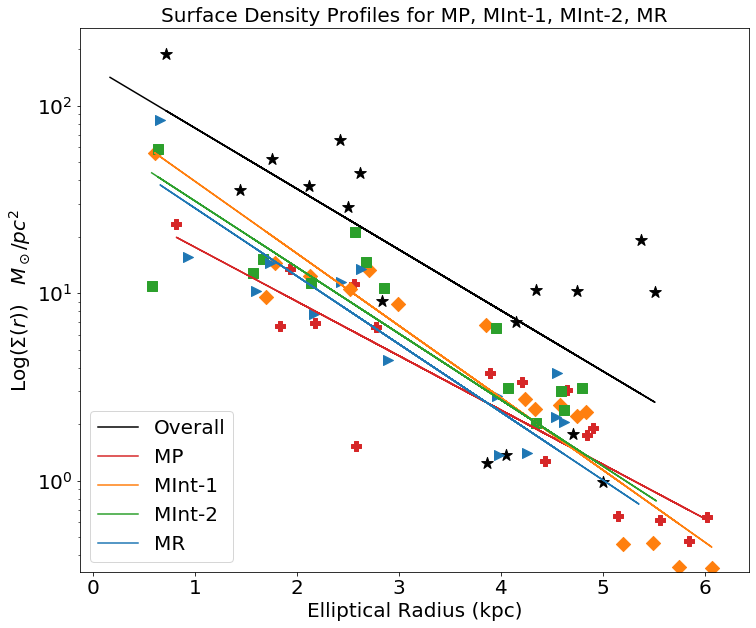

In [66]:
plt.figure(figsize=[12,10])

plt.plot(radii,np.exp(lmcdensityprofile_rm30dor(radii)),c='k',label='Overall')
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='tab:red',label='MP')
plt.plot(mint1_radii,np.exp(mint1profile(mint1_radii)),c='tab:orange',label='MInt-1')
plt.plot(mint2_radii,np.exp(mint2profile(mint2_radii)),c='tab:green',label='MInt-2')
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='tab:blue',label='MR')

plt.legend(loc='lower left',fontsize=20)

plt.scatter(radii_rm30dor,surfden_rm30dor,marker='*',c='k',s=150)
plt.scatter(mp_radii,mp_surfden,marker='P',c='tab:red',s=100)
plt.scatter(mint1_radii,mint1_surfden,marker='D',c='tab:orange',s=100)
plt.scatter(mint2_radii,mint2_surfden,marker='s',c='tab:green',s=100)
plt.scatter(mr_radii,mr_surfden,marker='>',c='tab:blue',s=100)

# plt.ylim(bottom=1)

plt.yscale('log')
plt.xlabel(r'Elliptical Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profiles for MP, MInt-1, MInt-2, MR',fontsize=20)

plt.savefig('allprofiles',bbox_inches='tight')
plt.show()

## All [Fe/H] Profiles Together

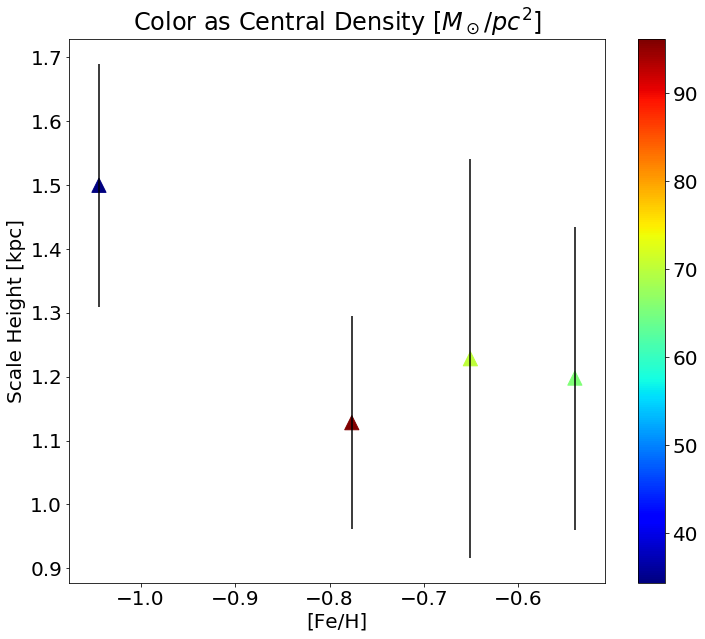

In [70]:
medage = [np.median(bloopr13[metal_poor]['FE_H']),np.median(bloopr13[m_int1]['FE_H']),
          np.median(bloopr13[m_int2]['FE_H']),np.median(bloopr13[metal_rich]['FE_H']),]

heights = [-np.reciprocal(mp_p[0]),-np.reciprocal(mint1_p[0]),-np.reciprocal(mint2_p[0]),-np.reciprocal(mr_p[0])]

heights_err = [mp_err[0]/(mp_p[0])**2,mint1_err[0]/(mp_p[0])**2,mint2_err[0]/(mp_p[0])**2,mr_err[0]/(mp_p[0])**2]

cen_den = [np.exp(mp_p[1]),np.exp(mint1_p[1]),np.exp(mint2_p[1]),np.exp(mr_p[1])]

plt.figure(figsize=[12,10])
plt.errorbar(medage,heights,yerr=heights_err,c='k',ls='none')
plt.scatter(medage,heights,marker='^',s=200,c=cen_den,cmap='jet')
plt.colorbar()
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Scale Height [kpc]')
plt.title(r'Color as Central Density [$M_\odot/pc^2$]')
plt.savefig('feh_scale.png',bbox_inches='tight')
plt.show()

# Age Bins

In [72]:
young = np.where(bloopage<=np.log10(0.5*10**9))
yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9)))
ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9)))
omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9)))
old = np.where(bloopage>np.log10(10.5*10**9))

r13young = bloopr13[young]
r13yless = bloopr13[yless]
r13ymed = bloopr13[ymed]
r13omed = bloopr13[omed]
r13old = bloopr13[old]

## Young

In [95]:
young_iso_ages = []
young_iso_zs = []

#fnt and brt bins
young_fbins = dens.brtfntlmc_bins(r13young)

for i in range(len(field_str)):
    fd = np.where(r13young['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(np.asarray(ages['AGE'])[young][fd]),
                                     np.median(r13young[fd]['FE_H']))
    young_iso_ages.append(age)
    young_iso_zs.append(z)

young_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13young['FIELD']==field_str[i]) 
    young_absHs.append(np.asarray(bloopabsH[young])[field_H])

young_sf_brites = []
young_sf_faints = []

for i in field_str:
    fld = np.where(r13young['FIELD']==i)
    
    fnts = np.where(r13young['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13young['TARGET_NAME'][fld]=='BrtRGB')
    
    young_sf_faints.append(r13young['SELECTFUNC'][fld][fnts])
    young_sf_brites.append(r13young['SELECTFUNC'][fld][brts])
        
young_field_masses = []
for i in range(len(field_str)):
    try:
        young_field_masses.append(dens.fieldmass(young_iso_ages[i],young_iso_zs[i],young_absHs[i],
                                                  young_sf_brites[i],young_sf_faints[i],parsec))
    except:
        young_field_masses.append(-9999.0)
        
for i in range(len(young_field_masses)):
    if np.isfinite(young_field_masses[i]) == False:
        young_field_masses[i] = -9999.0

0.8242508878488961 +/- 0.12869788789036707


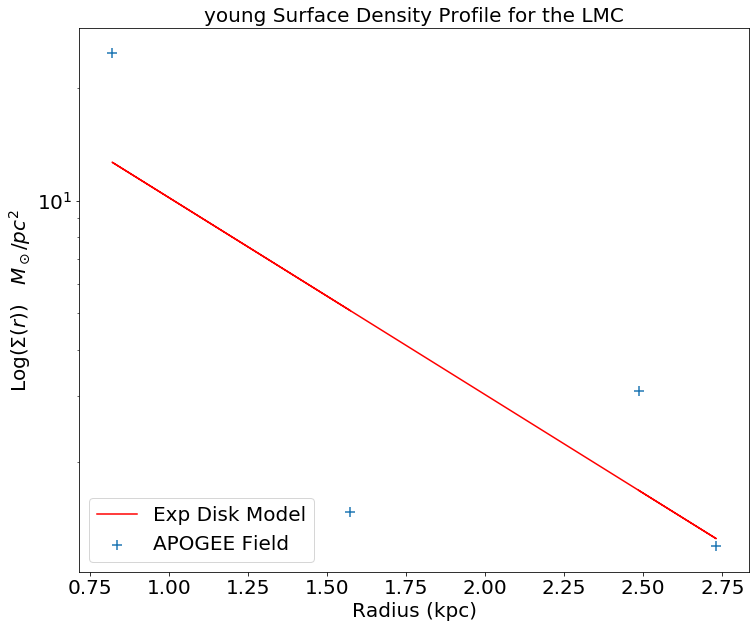

central: 34.339
scale: 0.824
err: 0.129


In [96]:
young_surfden = []
for i in range(len(young_field_masses)):
    young_surfden.append(np.divide(young_field_masses[i],field_areas[i]))

field_list = [np.where(r13young['FIELD']=='30Dor'),np.where(r13young['FIELD']=='LMC1'),
              np.where(r13young['FIELD']=='LMC2'),np.where(r13young['FIELD']=='LMC3'),
              np.where(r13young['FIELD']=='LMC4'),np.where(r13young['FIELD']=='LMC5'),
              np.where(r13young['FIELD']=='LMC6'),np.where(r13young['FIELD']=='LMC7'),
              np.where(r13young['FIELD']=='LMC8'),np.where(r13young['FIELD']=='LMC9'),
              np.where(r13young['FIELD']=='LMC10'),np.where(r13young['FIELD']=='LMC11'),
              np.where(r13young['FIELD']=='LMC12'),np.where(r13young['FIELD']=='LMC13'),
              np.where(r13young['FIELD']=='LMC14'),np.where(r13young['FIELD']=='LMC15'),
              np.where(r13young['FIELD']=='LMC16'),np.where(r13young['FIELD']=='LMC17')]

young_radii = []

x_young, y_young, _ = lgeo.LMCdisk_cart(r13young['RA'],r13young['DEC'])
ell_young = lgeo.elliptical_radius(x_young,y_young)
for i in range(len(field_str)):
    young_radii.append(np.median(ell_young[field_list[i]]))
    
good = np.where(np.asarray(young_surfden)>0.0)

young_radii = np.asarray(young_radii)[good]
young_surfden = np.asarray(young_surfden)[good]

young_p,young_err = ols.ols_fit(young_radii,np.log(young_surfden))
print(str(-1./young_p[0])+ ' +/- ' + str(err[0]/(young_p[0]**2)))

def youngprofile(r):
    return young_p[1]+np.multiply(young_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(young_radii,young_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(young_radii,np.exp(youngprofile(young_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('young Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('youngprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(young_p[1])))
print('scale: {:.3f}'.format(-np.reciprocal(young_p[0])))
print('err: {:.3f}'.format(err[0]/(young_p[0]**2)))

## Yless

In [97]:
yless_iso_ages = []
yless_iso_zs = []

#fnt and brt bins
yless_fbins = dens.brtfntlmc_bins(r13yless)

for i in range(len(field_str)):
    fd = np.where(r13yless['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(np.asarray(ages['AGE'])[yless][fd]),
                                     np.median(r13yless[fd]['FE_H']))
    yless_iso_ages.append(age)
    yless_iso_zs.append(z)

yless_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13yless['FIELD']==field_str[i]) 
    yless_absHs.append(np.asarray(bloopabsH[yless])[field_H])

yless_sf_brites = []
yless_sf_faints = []

for i in field_str:
    fld = np.where(r13yless['FIELD']==i)
    
    fnts = np.where(r13yless['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13yless['TARGET_NAME'][fld]=='BrtRGB')
    
    yless_sf_faints.append(r13yless['SELECTFUNC'][fld][fnts])
    yless_sf_brites.append(r13yless['SELECTFUNC'][fld][brts])
        
yless_field_masses = []
for i in range(len(field_str)):
    try:
        yless_field_masses.append(dens.fieldmass(yless_iso_ages[i],yless_iso_zs[i],yless_absHs[i],
                                                  yless_sf_brites[i],yless_sf_faints[i],parsec))
    except:
        yless_field_masses.append(-9999.0)
        
for i in range(len(yless_field_masses)):
    if np.isfinite(yless_field_masses[i]) == False:
        yless_field_masses[i] = -9999.0

1.5718219539407419 +/- 0.46801446173464906


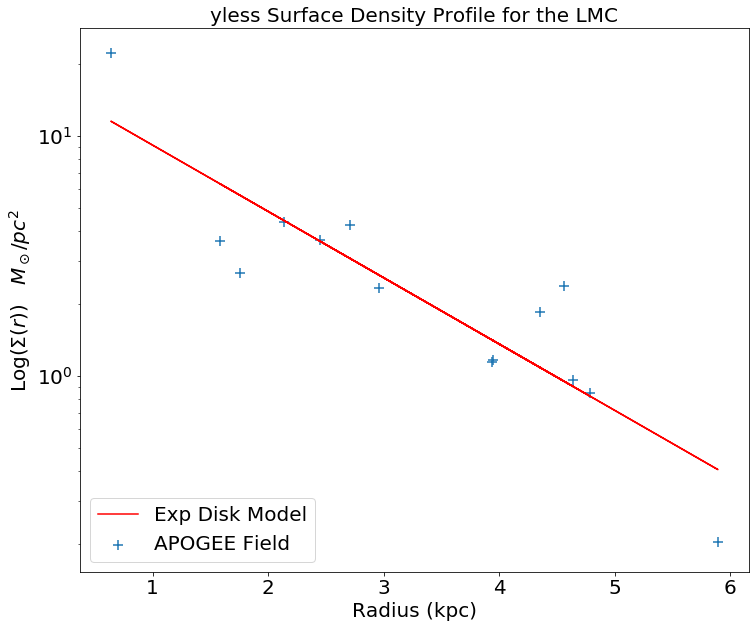

central: 17.271
scale: 1.572
err: 0.468


In [98]:
yless_surfden = []
for i in range(len(yless_field_masses)):
    yless_surfden.append(np.divide(yless_field_masses[i],field_areas[i]))

field_list = [np.where(r13yless['FIELD']=='30Dor'),np.where(r13yless['FIELD']=='LMC1'),
              np.where(r13yless['FIELD']=='LMC2'),np.where(r13yless['FIELD']=='LMC3'),
              np.where(r13yless['FIELD']=='LMC4'),np.where(r13yless['FIELD']=='LMC5'),
              np.where(r13yless['FIELD']=='LMC6'),np.where(r13yless['FIELD']=='LMC7'),
              np.where(r13yless['FIELD']=='LMC8'),np.where(r13yless['FIELD']=='LMC9'),
              np.where(r13yless['FIELD']=='LMC10'),np.where(r13yless['FIELD']=='LMC11'),
              np.where(r13yless['FIELD']=='LMC12'),np.where(r13yless['FIELD']=='LMC13'),
              np.where(r13yless['FIELD']=='LMC14'),np.where(r13yless['FIELD']=='LMC15'),
              np.where(r13yless['FIELD']=='LMC16'),np.where(r13yless['FIELD']=='LMC17')]

yless_radii = []

x_yless, y_yless, _ = lgeo.LMCdisk_cart(r13yless['RA'],r13yless['DEC'])
ell_yless = lgeo.elliptical_radius(x_yless,y_yless)
for i in range(len(field_str)):
    yless_radii.append(np.median(ell_yless[field_list[i]]))
    
good = np.where(np.asarray(yless_surfden)>0.0)

yless_radii = np.asarray(yless_radii)[good]
yless_surfden = np.asarray(yless_surfden)[good]

yless_p,yless_err = ols.ols_fit(yless_radii,np.log(yless_surfden))
print(str(-1./yless_p[0])+ ' +/- ' + str(err[0]/(yless_p[0]**2)))

def ylessprofile(r):
    return yless_p[1]+np.multiply(yless_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(yless_radii,yless_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(yless_radii,np.exp(ylessprofile(yless_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('yless Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('ylessprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(yless_p[1])))
print('scale: {:.3f}'.format(-np.reciprocal(yless_p[0])))
print('err: {:.3f}'.format(err[0]/(yless_p[0]**2)))

## Ymed

In [99]:
ymed_iso_ages = []
ymed_iso_zs = []

#fnt and brt bins
ymed_fbins = dens.brtfntlmc_bins(r13ymed)

for i in range(len(field_str)):
    fd = np.where(r13ymed['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(np.asarray(ages['AGE'])[ymed][fd]),
                                     np.median(r13ymed[fd]['FE_H']))
    ymed_iso_ages.append(age)
    ymed_iso_zs.append(z)

ymed_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13ymed['FIELD']==field_str[i]) 
    ymed_absHs.append(np.asarray(bloopabsH[ymed])[field_H])

ymed_sf_brites = []
ymed_sf_faints = []

for i in field_str:
    fld = np.where(r13ymed['FIELD']==i)
    
    fnts = np.where(r13ymed['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13ymed['TARGET_NAME'][fld]=='BrtRGB')
    
    ymed_sf_faints.append(r13ymed['SELECTFUNC'][fld][fnts])
    ymed_sf_brites.append(r13ymed['SELECTFUNC'][fld][brts])
        
ymed_field_masses = []
for i in range(len(field_str)):
    try:
        ymed_field_masses.append(dens.fieldmass(ymed_iso_ages[i],ymed_iso_zs[i],ymed_absHs[i],
                                                  ymed_sf_brites[i],ymed_sf_faints[i],parsec))
    except:
        ymed_field_masses.append(-9999.0)
        
for i in range(len(ymed_field_masses)):
    if np.isfinite(ymed_field_masses[i]) == False:
        ymed_field_masses[i] = -9999.0

1.3583288828268971 +/- 0.34951228324424666


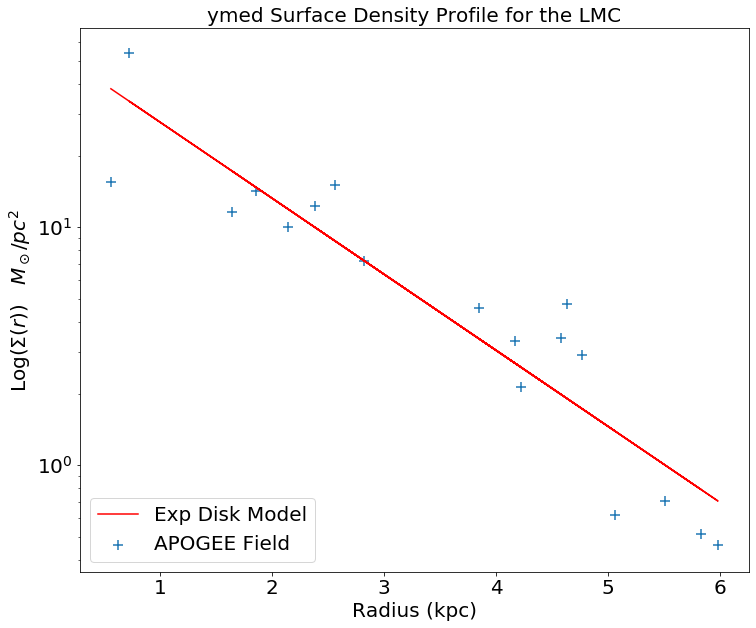

central: 57.750
scale: 1.358
err: 0.350


In [100]:
ymed_surfden = []
for i in range(len(ymed_field_masses)):
    ymed_surfden.append(np.divide(ymed_field_masses[i],field_areas[i]))

field_list = [np.where(r13ymed['FIELD']=='30Dor'),np.where(r13ymed['FIELD']=='LMC1'),
              np.where(r13ymed['FIELD']=='LMC2'),np.where(r13ymed['FIELD']=='LMC3'),
              np.where(r13ymed['FIELD']=='LMC4'),np.where(r13ymed['FIELD']=='LMC5'),
              np.where(r13ymed['FIELD']=='LMC6'),np.where(r13ymed['FIELD']=='LMC7'),
              np.where(r13ymed['FIELD']=='LMC8'),np.where(r13ymed['FIELD']=='LMC9'),
              np.where(r13ymed['FIELD']=='LMC10'),np.where(r13ymed['FIELD']=='LMC11'),
              np.where(r13ymed['FIELD']=='LMC12'),np.where(r13ymed['FIELD']=='LMC13'),
              np.where(r13ymed['FIELD']=='LMC14'),np.where(r13ymed['FIELD']=='LMC15'),
              np.where(r13ymed['FIELD']=='LMC16'),np.where(r13ymed['FIELD']=='LMC17')]

ymed_radii = []

x_ymed, y_ymed, _ = lgeo.LMCdisk_cart(r13ymed['RA'],r13ymed['DEC'])
ell_ymed = lgeo.elliptical_radius(x_ymed,y_ymed)
for i in range(len(field_str)):
    ymed_radii.append(np.median(ell_ymed[field_list[i]]))
    
good = np.where(np.asarray(ymed_surfden)>0.0)

ymed_radii = np.asarray(ymed_radii)[good]
ymed_surfden = np.asarray(ymed_surfden)[good]

ymed_p,ymed_err = ols.ols_fit(ymed_radii,np.log(ymed_surfden))
print(str(-1./ymed_p[0])+ ' +/- ' + str(err[0]/(ymed_p[0]**2)))

def ymedprofile(r):
    return ymed_p[1]+np.multiply(ymed_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(ymed_radii,ymed_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(ymed_radii,np.exp(ymedprofile(ymed_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('ymed Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('ymedprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(ymed_p[1])))
print('scale: {:.3f}'.format(-np.reciprocal(ymed_p[0])))
print('err: {:.3f}'.format(err[0]/(ymed_p[0]**2)))

## Omed

In [101]:
omed_iso_ages = []
omed_iso_zs = []

#fnt and brt bins
omed_fbins = dens.brtfntlmc_bins(r13omed)

for i in range(len(field_str)):
    fd = np.where(r13omed['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(np.asarray(ages['AGE'])[omed][fd]),
                                     np.median(r13omed[fd]['FE_H']))
    omed_iso_ages.append(age)
    omed_iso_zs.append(z)

omed_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13omed['FIELD']==field_str[i]) 
    omed_absHs.append(np.asarray(bloopabsH[omed])[field_H])

omed_sf_brites = []
omed_sf_faints = []

for i in field_str:
    fld = np.where(r13omed['FIELD']==i)
    
    fnts = np.where(r13omed['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13omed['TARGET_NAME'][fld]=='BrtRGB')
    
    omed_sf_faints.append(r13omed['SELECTFUNC'][fld][fnts])
    omed_sf_brites.append(r13omed['SELECTFUNC'][fld][brts])
        
omed_field_masses = []
for i in range(len(field_str)):
    try:
        omed_field_masses.append(dens.fieldmass(omed_iso_ages[i],omed_iso_zs[i],omed_absHs[i],
                                                  omed_sf_brites[i],omed_sf_faints[i],parsec))
    except:
        omed_field_masses.append(-9999.0)
        
for i in range(len(omed_field_masses)):
    if np.isfinite(omed_field_masses[i]) == False:
        omed_field_masses[i] = -9999.0

1.16757000023865 +/- 0.25823697610547364


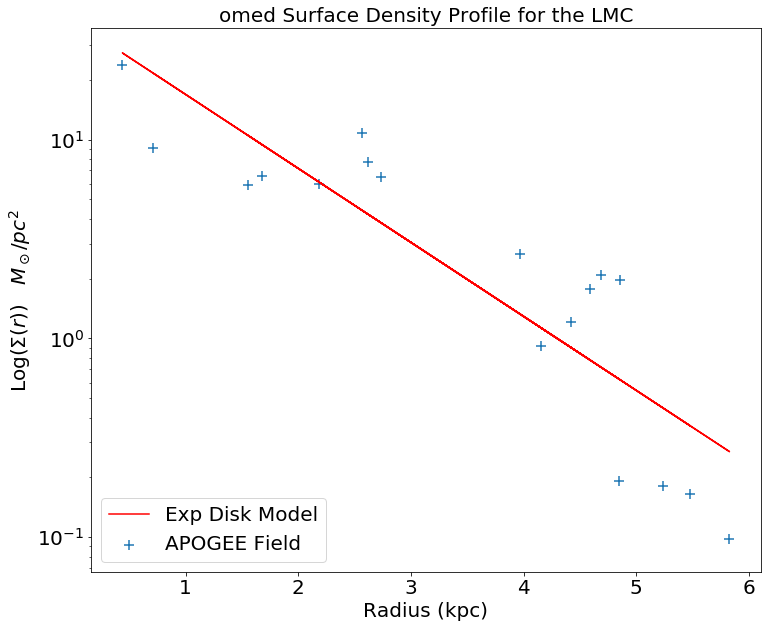

central: 39.701
scale: 1.168
err: 0.258


In [102]:
omed_surfden = []
for i in range(len(omed_field_masses)):
    omed_surfden.append(np.divide(omed_field_masses[i],field_areas[i]))

field_list = [np.where(r13omed['FIELD']=='30Dor'),np.where(r13omed['FIELD']=='LMC1'),
              np.where(r13omed['FIELD']=='LMC2'),np.where(r13omed['FIELD']=='LMC3'),
              np.where(r13omed['FIELD']=='LMC4'),np.where(r13omed['FIELD']=='LMC5'),
              np.where(r13omed['FIELD']=='LMC6'),np.where(r13omed['FIELD']=='LMC7'),
              np.where(r13omed['FIELD']=='LMC8'),np.where(r13omed['FIELD']=='LMC9'),
              np.where(r13omed['FIELD']=='LMC10'),np.where(r13omed['FIELD']=='LMC11'),
              np.where(r13omed['FIELD']=='LMC12'),np.where(r13omed['FIELD']=='LMC13'),
              np.where(r13omed['FIELD']=='LMC14'),np.where(r13omed['FIELD']=='LMC15'),
              np.where(r13omed['FIELD']=='LMC16'),np.where(r13omed['FIELD']=='LMC17')]

omed_radii = []

x_omed, y_omed, _ = lgeo.LMCdisk_cart(r13omed['RA'],r13omed['DEC'])
ell_omed = lgeo.elliptical_radius(x_omed,y_omed)
for i in range(len(field_str)):
    omed_radii.append(np.median(ell_omed[field_list[i]]))
    
good = np.where(np.asarray(omed_surfden)>0.0)

omed_radii = np.asarray(omed_radii)[good]
omed_surfden = np.asarray(omed_surfden)[good]

omed_p,omed_err = ols.ols_fit(omed_radii,np.log(omed_surfden))
print(str(-1./omed_p[0])+ ' +/- ' + str(err[0]/(omed_p[0]**2)))

def omedprofile(r):
    return omed_p[1]+np.multiply(omed_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(omed_radii,omed_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(omed_radii,np.exp(omedprofile(omed_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('omed Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('omedprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(omed_p[1])))
print('scale: {:.3f}'.format(-np.reciprocal(omed_p[0])))
print('err: {:.3f}'.format(err[0]/(omed_p[0]**2)))

## Old

In [103]:
old_iso_ages = []
old_iso_zs = []

#fnt and brt bins
old_fbins = dens.brtfntlmc_bins(r13old)

for i in range(len(field_str)):
    fd = np.where(r13old['FIELD']==field_str[i])
    age, z = dens.findclosestparsec(parsec,np.median(np.asarray(ages['AGE'])[old][fd]),
                                     np.median(r13old[fd]['FE_H']))
    old_iso_ages.append(age)
    old_iso_zs.append(z)

old_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13old['FIELD']==field_str[i]) 
    old_absHs.append(np.asarray(bloopabsH[old])[field_H])

old_sf_brites = []
old_sf_faints = []

for i in field_str:
    fld = np.where(r13old['FIELD']==i)
    
    fnts = np.where(r13old['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13old['TARGET_NAME'][fld]=='BrtRGB')
    
    old_sf_faints.append(r13old['SELECTFUNC'][fld][fnts])
    old_sf_brites.append(r13old['SELECTFUNC'][fld][brts])
        
old_field_masses = []
for i in range(len(field_str)):
    try:
        old_field_masses.append(dens.fieldmass(old_iso_ages[i],old_iso_zs[i],old_absHs[i],
                                                  old_sf_brites[i],old_sf_faints[i],parsec))
    except:
        old_field_masses.append(-9999.0)
        
for i in range(len(old_field_masses)):
    if np.isfinite(old_field_masses[i]) == False:
        old_field_masses[i] = -9999.0

0.8930569223431422 +/- 0.15108134924619532


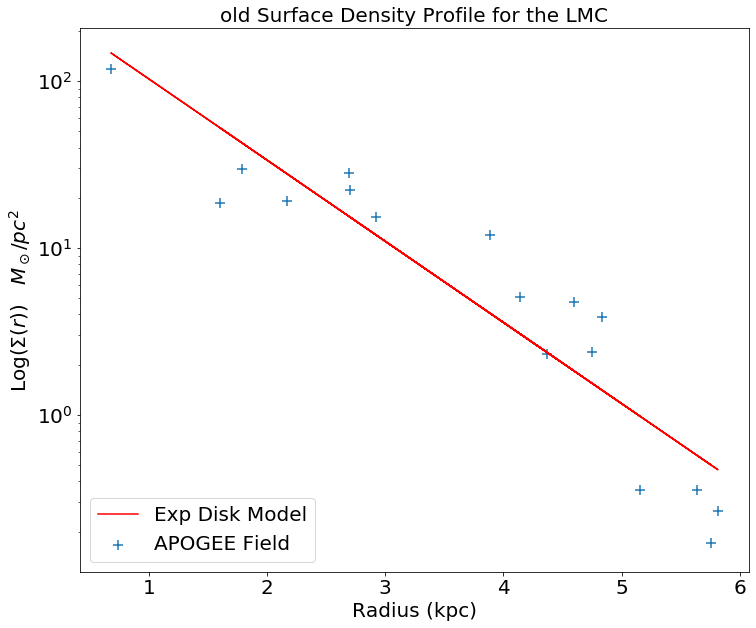

central: 316.033
scale: 0.893
err: 0.151


In [104]:
old_surfden = []
for i in range(len(old_field_masses)):
    old_surfden.append(np.divide(old_field_masses[i],field_areas[i]))

field_list = [np.where(r13old['FIELD']=='30Dor'),np.where(r13old['FIELD']=='LMC1'),
              np.where(r13old['FIELD']=='LMC2'),np.where(r13old['FIELD']=='LMC3'),
              np.where(r13old['FIELD']=='LMC4'),np.where(r13old['FIELD']=='LMC5'),
              np.where(r13old['FIELD']=='LMC6'),np.where(r13old['FIELD']=='LMC7'),
              np.where(r13old['FIELD']=='LMC8'),np.where(r13old['FIELD']=='LMC9'),
              np.where(r13old['FIELD']=='LMC10'),np.where(r13old['FIELD']=='LMC11'),
              np.where(r13old['FIELD']=='LMC12'),np.where(r13old['FIELD']=='LMC13'),
              np.where(r13old['FIELD']=='LMC14'),np.where(r13old['FIELD']=='LMC15'),
              np.where(r13old['FIELD']=='LMC16'),np.where(r13old['FIELD']=='LMC17')]

old_radii = []

x_old, y_old, _ = lgeo.LMCdisk_cart(r13old['RA'],r13old['DEC'])
ell_old = lgeo.elliptical_radius(x_old,y_old)
for i in range(len(field_str)):
    old_radii.append(np.median(ell_old[field_list[i]]))
    
good = np.where(np.asarray(old_surfden)>0.0)

old_radii = np.asarray(old_radii)[good]
old_surfden = np.asarray(old_surfden)[good]

# rm 30 Dor
old_radii = np.delete(old_radii,0)
old_surfden = np.delete(old_surfden,0)

old_p,old_err = ols.ols_fit(old_radii,np.log(old_surfden))
print(str(-1./old_p[0])+ ' +/- ' + str(err[0]/(old_p[0]**2)))

def oldprofile(r):
    return old_p[1]+np.multiply(old_p[0],r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(old_radii,old_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(old_radii,np.exp(oldprofile(old_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('old Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('oldprofile.pdf',bbox_inches='tight')
plt.show()

print('central: {:.3f}'.format(np.exp(old_p[1])))
print('scale: {:.3f}'.format(-np.reciprocal(old_p[0])))
print('err: {:.3f}'.format(err[0]/(old_p[0]**2)))

## All Age Profiles Together

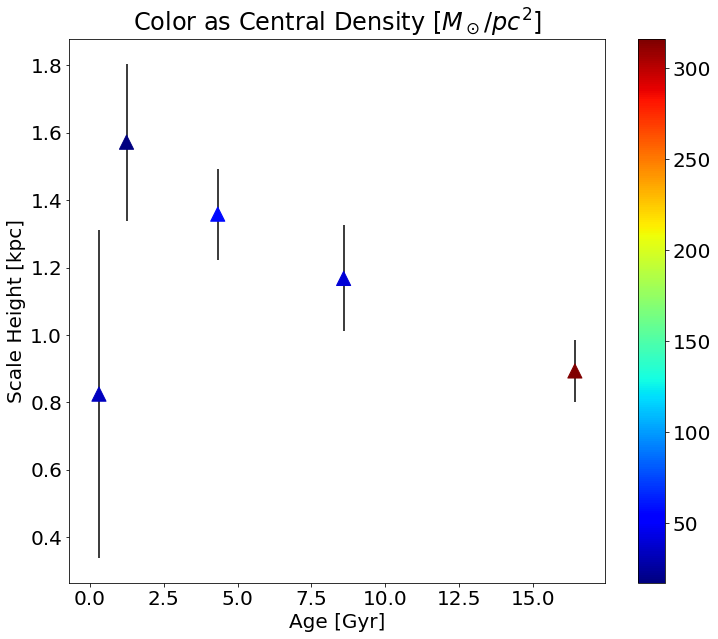

In [111]:
medage = [np.median(10**bloopage[young])/10**9,np.median(10**bloopage[yless])/10**9,
          np.median(10**bloopage[ymed])/10**9,np.median(10**bloopage[omed])/10**9,
          np.median(10**bloopage[old][np.where(bloopage[old]<=10.5)])/10**9]

widths = [util.mad(10**bloopage[young]/10**9),util.mad(10**bloopage[yless]/10**9),
          util.mad(10**bloopage[ymed]/10**9),util.mad(10**bloopage[omed]/10**9),
          util.mad(10**bloopage[old][np.where(bloopage[old]<=10.5)]/10**9)]

heights = [-np.reciprocal(young_p[0]),-np.reciprocal(yless_p[0]),-np.reciprocal(ymed_p[0]),
           -np.reciprocal(omed_p[0]),-np.reciprocal(old_p[0])]

heights_err = [young_err[0]/(young_p[0])**2,yless_err[0]/(yless_p[0])**2,ymed_err[0]/(ymed_p[0])**2,
               omed_err[0]/(omed_p[0])**2,old_err[0]/(old_p[0])**2]

cen_den = [np.exp(young_p[1]),np.exp(yless_p[1]),np.exp(ymed_p[1]),np.exp(omed_p[1]),np.exp(old_p[1])]

plt.figure(figsize=[12,10])
plt.errorbar(medage,heights,yerr=heights_err,c='k',ls='none',zorder=1)
plt.scatter(medage,heights,marker='^',s=200,c=cen_den,cmap='jet',zorder=2)
plt.colorbar()
plt.xlabel(r'Age [Gyr]')
plt.ylabel(r'Scale Height [kpc]')
plt.title(r'Color as Central Density [$M_\odot/pc^2$]')
plt.savefig('age_scale',bbox_inches='tight')
plt.show()

<font size='20'>
    <b>
        Bin Age and Metallicity
    </b>
</font>

# MP

In [141]:
### MP
mp_young = np.where((bloopage<=np.log10(0.5*10**9))&(bloopr13['FE_H']<-0.87833154))
mp_yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(bloopr13['FE_H']<-0.87833154))
mp_ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(bloopr13['FE_H']<-0.87833154))
mp_omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(bloopr13['FE_H']<-0.87833154))
mp_old = np.where((bloopage>np.log10(10.5*10**9))&(bloopr13['FE_H']<-0.87833154))
mps = [mp_young,mp_yless,mp_ymed,mp_omed,mp_old]

# APOGEE
mpr13young = bloopr13[mp_young]
mpr13yless = bloopr13[mp_yless]
mpr13ymed = bloopr13[mp_ymed]
mpr13omed = bloopr13[mp_omed]
mpr13old = bloopr13[mp_old]
mpr13s = [bloopr13[mp_young],bloopr13[mp_yless],bloopr13[mp_ymed],bloopr13[mp_omed],bloopr13[mp_old]]

# ages
mp_young_ages = bloopage[mp_young]
mp_yless_ages = bloopage[mp_yless]
mp_ymed_ages = bloopage[mp_ymed]
mp_omed_ages = bloopage[mp_omed]
mp_old_ages = bloopage[mp_old]
mp_ages = [bloopage[mp_young],bloopage[mp_yless],bloopage[mp_ymed],bloopage[mp_omed],bloopage[mp_old]]

# mags
mp_young_H = bloopabsH[mp_young]
mp_yless_H = bloopabsH[mp_yless]
mp_ymed_H = bloopabsH[mp_ymed]
mp_omed_H = bloopabsH[mp_omed]
mp_old_H = bloopabsH[mp_old]
mp_Hs = [bloopabsH[mp_young],bloopabsH[mp_yless],bloopabsH[mp_ymed],bloopabsH[mp_omed],bloopabsH[mp_old]]

# print numbers in bins
print('mp_young ',len(np.squeeze(mp_young)))
print('mp_yless ',len(np.squeeze(mp_yless)))
print('mp_ymed ',len(np.squeeze(mp_ymed)))
print('mp_omed ',len(np.squeeze(mp_omed)))
print('mp_old ',len(np.squeeze(mp_old)))

mp_young  23
mp_yless  76
mp_ymed  184
mp_omed  81
mp_old  259


In [167]:
all_mps_radii = []
all_mps_surfden = []

for i in tqdm_notebook(range(len(mps))):
    mps_iso_ages = []
    mps_iso_fehs = []
    field_absHs = []

    #fnt and brt bins
    mps_fbins = dens.brtfntlmc_bins(mpr13s[i])
    

    for j in range(len(field_str)):
        fd = np.where(mpr13s[i]['FIELD']==field_str[j])
        age, feh = dens.findclosestparsec(parsec,np.median([fd]),np.median(mpr13s[i][fd]['FE_H']))
        mps_iso_ages.append(age)
        mps_iso_fehs.append(feh)
        
        field_absHs.append(np.asarray(mp_Hs[i])[fd])
        
#     print(mps_iso_ages)
#     print(mps_iso_fehs)
#     print(field_absHs)

    mp_sfs_brites = []
    mp_sfs_faints = []

    for j in field_str:
        fld = np.where(mpr13s[i]['FIELD']==j)
    
        fnts = np.where(mpr13s[i]['TARGET_NAME'][fld]=='FntRGB')
        brts = np.where(mpr13s[i]['TARGET_NAME'][fld]=='BrtRGB')
    
        mp_sfs_faints.append(mpr13s[i]['SELECTFUNC'][fld][fnts])
        mp_sfs_brites.append(mpr13s[i]['SELECTFUNC'][fld][brts])
        
#     print(mp_sfs_faints)
#     print(mp_sfs_brites)
#     print(' ')

    mps_field_masses = []
    for j in range(len(field_str)):
        try:
            mps_field_masses.append(dens.fieldmass(mps_iso_ages[j],mps_iso_fehs[j],field_absHs[j],
                                                   mp_sfs_brites[j],mp_sfs_faints[j],parsec))
        except:
            mps_field_masses.append(-9999.0)
        
    for j in range(len(mps_field_masses)):
        if np.isfinite(mps_field_masses[j]) == False:
            mps_field_masses[j] = -9999.0        
            
#     print(mps_field_masses)
#     print(' +++ ')
            
    mps_surfden = []
    for j in range(len(mps_field_masses)):
        mps_surfden.append(np.divide(mps_field_masses[j],field_areas[j]))

    field_list = [np.where(mpr13s[i]['FIELD']=='30Dor'),np.where(mpr13s[i]['FIELD']=='LMC1'),
                  np.where(mpr13s[i]['FIELD']=='LMC2'),np.where(mpr13s[i]['FIELD']=='LMC3'),
                  np.where(mpr13s[i]['FIELD']=='LMC4'),np.where(mpr13s[i]['FIELD']=='LMC5'),
                  np.where(mpr13s[i]['FIELD']=='LMC6'),np.where(mpr13s[i]['FIELD']=='LMC7'),
                  np.where(mpr13s[i]['FIELD']=='LMC8'),np.where(mpr13s[i]['FIELD']=='LMC9'),
                  np.where(mpr13s[i]['FIELD']=='LMC10'),np.where(mpr13s[i]['FIELD']=='LMC11'),
                  np.where(mpr13s[i]['FIELD']=='LMC12'),np.where(mpr13s[i]['FIELD']=='LMC13'),
                  np.where(mpr13s[i]['FIELD']=='LMC14'),np.where(mpr13s[i]['FIELD']=='LMC15'),
                  np.where(mpr13s[i]['FIELD']=='LMC16'),np.where(mpr13s[i]['FIELD']=='LMC17')]

    mps_radii = []

    x_mps, y_mps, _ = lgeo.LMCdisk_cart(mpr13s[i]['RA'],mpr13s[i]['DEC'])
    ell_mps = lgeo.elliptical_radius(x_mps,y_mps)
    for j in range(len(field_str)):
        mps_radii.append(np.median(ell_mps[field_list[j]]))
        
    for j in range(len(mps_radii)):
        if np.isfinite(mps_radii[j]) == False:
            mps_radii[j] = -9999.0
        
#     print(mps_radii)
#     print(len(mps_radii))
    
    good = np.where(np.asarray(mps_surfden)>0.0)

    mps_radii = np.asarray(mps_radii)[good]
    mps_surfden = np.asarray(mps_surfden)[good]
    
#     print(mps_radii)
#     print(mps_surfden)
#     print("+++")
    
    all_mps_radii.append(mps_radii)
    all_mps_surfden.append(mps_surfden)
    
all_mps_ps = []
all_mps_errs = []
for i in range(len(mps)):
    try:
        mps_ps,mps_errs = ols.ols_fit(all_mps_radii[i],np.log(all_mps_surfden[i]))
#     print(str(-1./mps_p[0])+ ' +/- ' + str(mps_errs[0]/(mps_p[0]**2)))
        all_mps_ps.append(mps_ps)
        all_mps_errs.append(mps_errs)
        
    except:
        all_mps_ps.append(np.array([-9999.0,-9999.0]))
        all_mps_errs.append(np.array([-9999.0,-9999.0]))

# Mint1

In [165]:
### mint1
mint1_young = np.where((bloopage<=np.log10(0.5*10**9))&(bloopr13['FE_H']>=-0.87833154)&
                       (bloopr13['FE_H']<-0.7067915))
mint1_yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&
                       (bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
mint1_ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&
                      (bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
mint1_omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&
                      (bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
mint1_old = np.where((bloopage>np.log10(10.5*10**9))&(bloopr13['FE_H']>=-0.87833154)&
                     (bloopr13['FE_H']<-0.7067915))
mint1s = [mint1_young,mint1_yless,mint1_ymed,mint1_omed,mint1_old]

# APOGEE
mint1r13young = bloopr13[mint1_young]
mint1r13yless = bloopr13[mint1_yless]
mint1r13ymed = bloopr13[mint1_ymed]
mint1r13omed = bloopr13[mint1_omed]
mint1r13old = bloopr13[mint1_old]
mint1r13s = [bloopr13[mint1_young],bloopr13[mint1_yless],bloopr13[mint1_ymed],bloopr13[mint1_omed],
             bloopr13[mint1_old]]

# ages
mint1_young_ages = bloopage[mint1_young]
mint1_yless_ages = bloopage[mint1_yless]
mint1_ymed_ages = bloopage[mint1_ymed]
mint1_omed_ages = bloopage[mint1_omed]
mint1_old_ages = bloopage[mint1_old]
mint1_ages = [bloopage[mint1_young],bloopage[mint1_yless],bloopage[mint1_ymed],bloopage[mint1_omed],
              bloopage[mint1_old]]

# mags
mint1_young_H = bloopabsH[mint1_young]
mint1_yless_H = bloopabsH[mint1_yless]
mint1_ymed_H = bloopabsH[mint1_ymed]
mint1_omed_H = bloopabsH[mint1_omed]
mint1_old_H = bloopabsH[mint1_old]
mint1_Hs = [bloopabsH[mint1_young],bloopabsH[mint1_yless],bloopabsH[mint1_ymed],bloopabsH[mint1_omed],
            bloopabsH[mint1_old]]

# print numbers in bins
print('mint1_young ',len(np.squeeze(mint1_young)))
print('mint1_yless ',len(np.squeeze(mint1_yless)))
print('mint1_ymed ',len(np.squeeze(mint1_ymed)))
print('mint1_omed ',len(np.squeeze(mint1_omed)))
print('mint1_old ',len(np.squeeze(mint1_old)))

mint1_young  5
mint1_yless  44
mint1_ymed  123
mint1_omed  78
mint1_old  394


In [168]:
all_mint1s_radii = []
all_mint1s_surfden = []

for i in tqdm_notebook(range(len(mint1s))):
    mint1s_iso_ages = []
    mint1s_iso_fehs = []
    field_absHs = []

    #fnt and brt bins
    mint1s_fbins = dens.brtfntlmc_bins(mint1r13s[i])
    

    for j in range(len(field_str)):
        fd = np.where(mint1r13s[i]['FIELD']==field_str[j])
        age, feh = dens.findclosestparsec(parsec,np.median([fd]),np.median(mint1r13s[i][fd]['FE_H']))
        mint1s_iso_ages.append(age)
        mint1s_iso_fehs.append(feh)
        
        field_absHs.append(np.asarray(mint1_Hs[i])[fd])
        
#     print(mint1s_iso_ages)
#     print(mint1s_iso_fehs)
#     print(field_absHs)

    mint1_sfs_brites = []
    mint1_sfs_faints = []

    for j in field_str:
        fld = np.where(mint1r13s[i]['FIELD']==j)
    
        fnts = np.where(mint1r13s[i]['TARGET_NAME'][fld]=='FntRGB')
        brts = np.where(mint1r13s[i]['TARGET_NAME'][fld]=='BrtRGB')
    
        mint1_sfs_faints.append(mint1r13s[i]['SELECTFUNC'][fld][fnts])
        mint1_sfs_brites.append(mint1r13s[i]['SELECTFUNC'][fld][brts])
        
#     print(mint1_sfs_faints)
#     print(mint1_sfs_brites)
#     print(' ')

    mint1s_field_masses = []
    for j in range(len(field_str)):
        try:
            mint1s_field_masses.append(dens.fieldmass(mint1s_iso_ages[j],mint1s_iso_fehs[j],field_absHs[j],
                                                   mint1_sfs_brites[j],mint1_sfs_faints[j],parsec))
        except:
            mint1s_field_masses.append(-9999.0)
        
    for j in range(len(mint1s_field_masses)):
        if np.isfinite(mint1s_field_masses[j]) == False:
            mint1s_field_masses[j] = -9999.0        
            
#     print(mint1s_field_masses)
#     print(' +++ ')
            
    mint1s_surfden = []
    for j in range(len(mint1s_field_masses)):
        mint1s_surfden.append(np.divide(mint1s_field_masses[j],field_areas[j]))

    field_list = [np.where(mint1r13s[i]['FIELD']=='30Dor'),np.where(mint1r13s[i]['FIELD']=='LMC1'),
                  np.where(mint1r13s[i]['FIELD']=='LMC2'),np.where(mint1r13s[i]['FIELD']=='LMC3'),
                  np.where(mint1r13s[i]['FIELD']=='LMC4'),np.where(mint1r13s[i]['FIELD']=='LMC5'),
                  np.where(mint1r13s[i]['FIELD']=='LMC6'),np.where(mint1r13s[i]['FIELD']=='LMC7'),
                  np.where(mint1r13s[i]['FIELD']=='LMC8'),np.where(mint1r13s[i]['FIELD']=='LMC9'),
                  np.where(mint1r13s[i]['FIELD']=='LMC10'),np.where(mint1r13s[i]['FIELD']=='LMC11'),
                  np.where(mint1r13s[i]['FIELD']=='LMC12'),np.where(mint1r13s[i]['FIELD']=='LMC13'),
                  np.where(mint1r13s[i]['FIELD']=='LMC14'),np.where(mint1r13s[i]['FIELD']=='LMC15'),
                  np.where(mint1r13s[i]['FIELD']=='LMC16'),np.where(mint1r13s[i]['FIELD']=='LMC17')]

    mint1s_radii = []

    x_mint1s, y_mint1s, _ = lgeo.LMCdisk_cart(mint1r13s[i]['RA'],mint1r13s[i]['DEC'])
    ell_mint1s = lgeo.elliptical_radius(x_mint1s,y_mint1s)
    for j in range(len(field_str)):
        mint1s_radii.append(np.median(ell_mint1s[field_list[j]]))
        
    for j in range(len(mint1s_radii)):
        if np.isfinite(mint1s_radii[j]) == False:
            mint1s_radii[j] = -9999.0
        
#     print(mint1s_radii)
#     print(len(mint1s_radii))
    
    good = np.where(np.asarray(mint1s_surfden)>0.0)

    mint1s_radii = np.asarray(mint1s_radii)[good]
    mint1s_surfden = np.asarray(mint1s_surfden)[good]
    
#     print(mint1s_radii)
#     print(mint1s_surfden)
#     print("+++")
    
    all_mint1s_radii.append(mint1s_radii)
    all_mint1s_surfden.append(mint1s_surfden)
    
all_mint1s_ps = []
all_mint1s_errs = []
for i in range(len(mint1s)):
    try:
        mint1s_ps,mint1s_errs = ols.ols_fit(all_mint1s_radii[i],np.log(all_mint1s_surfden[i]))
#     print(str(-1./mint1s_p[0])+ ' +/- ' + str(mint1s_errs[0]/(mint1s_p[0]**2)))
        all_mint1s_ps.append(mint1s_ps)
        all_mint1s_errs.append(mint1s_errs)
        
    except:
        all_mint1s_ps.append(np.array([-9999.0,-9999.0]))
        all_mint1s_errs.append(np.array([-9999.0,-9999.0]))

# Mint2

In [170]:
### mint2
mint2_young = np.where((bloopage<=np.log10(0.5*10**9))&(bloopr13['FE_H']>=-0.87833154)&
                       (bloopr13['FE_H']<-0.7067915))
mint2_yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&
                       (bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
mint2_ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&
                      (bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
mint2_omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&
                      (bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
mint2_old = np.where((bloopage>np.log10(10.5*10**9))&(bloopr13['FE_H']>=-0.87833154)&
                     (bloopr13['FE_H']<-0.7067915))
mint2s = [mint2_young,mint2_yless,mint2_ymed,mint2_omed,mint2_old]

# APOGEE
mint2r13young = bloopr13[mint2_young]
mint2r13yless = bloopr13[mint2_yless]
mint2r13ymed = bloopr13[mint2_ymed]
mint2r13omed = bloopr13[mint2_omed]
mint2r13old = bloopr13[mint2_old]
mint2r13s = [bloopr13[mint2_young],bloopr13[mint2_yless],bloopr13[mint2_ymed],bloopr13[mint2_omed],
             bloopr13[mint2_old]]

# ages
mint2_young_ages = bloopage[mint2_young]
mint2_yless_ages = bloopage[mint2_yless]
mint2_ymed_ages = bloopage[mint2_ymed]
mint2_omed_ages = bloopage[mint2_omed]
mint2_old_ages = bloopage[mint2_old]
mint2_ages = [bloopage[mint2_young],bloopage[mint2_yless],bloopage[mint2_ymed],bloopage[mint2_omed],
              bloopage[mint2_old]]

# mags
mint2_young_H = bloopabsH[mint2_young]
mint2_yless_H = bloopabsH[mint2_yless]
mint2_ymed_H = bloopabsH[mint2_ymed]
mint2_omed_H = bloopabsH[mint2_omed]
mint2_old_H = bloopabsH[mint2_old]
mint2_Hs = [bloopabsH[mint2_young],bloopabsH[mint2_yless],bloopabsH[mint2_ymed],bloopabsH[mint2_omed],
            bloopabsH[mint2_old]]

# print numbers in bins
print('mint2_young ',len(np.squeeze(mint2_young)))
print('mint2_yless ',len(np.squeeze(mint2_yless)))
print('mint2_ymed ',len(np.squeeze(mint2_ymed)))
print('mint2_omed ',len(np.squeeze(mint2_omed)))
print('mint2_old ',len(np.squeeze(mint2_old)))

mint2_young  5
mint2_yless  44
mint2_ymed  123
mint2_omed  78
mint2_old  394


In [171]:
all_mint2s_radii = []
all_mint2s_surfden = []

for i in tqdm_notebook(range(len(mint2s))):
    mint2s_iso_ages = []
    mint2s_iso_fehs = []
    field_absHs = []

    #fnt and brt bins
    mint2s_fbins = dens.brtfntlmc_bins(mint2r13s[i])
    

    for j in range(len(field_str)):
        fd = np.where(mint2r13s[i]['FIELD']==field_str[j])
        age, feh = dens.findclosestparsec(parsec,np.median([fd]),np.median(mint2r13s[i][fd]['FE_H']))
        mint2s_iso_ages.append(age)
        mint2s_iso_fehs.append(feh)
        
        field_absHs.append(np.asarray(mint2_Hs[i])[fd])
        
#     print(mint2s_iso_ages)
#     print(mint2s_iso_fehs)
#     print(field_absHs)

    mint2_sfs_brites = []
    mint2_sfs_faints = []

    for j in field_str:
        fld = np.where(mint2r13s[i]['FIELD']==j)
    
        fnts = np.where(mint2r13s[i]['TARGET_NAME'][fld]=='FntRGB')
        brts = np.where(mint2r13s[i]['TARGET_NAME'][fld]=='BrtRGB')
    
        mint2_sfs_faints.append(mint2r13s[i]['SELECTFUNC'][fld][fnts])
        mint2_sfs_brites.append(mint2r13s[i]['SELECTFUNC'][fld][brts])
        
#     print(mint2_sfs_faints)
#     print(mint2_sfs_brites)
#     print(' ')

    mint2s_field_masses = []
    for j in range(len(field_str)):
        try:
            mint2s_field_masses.append(dens.fieldmass(mint2s_iso_ages[j],mint2s_iso_fehs[j],field_absHs[j],
                                                   mint2_sfs_brites[j],mint2_sfs_faints[j],parsec))
        except:
            mint2s_field_masses.append(-9999.0)
        
    for j in range(len(mint2s_field_masses)):
        if np.isfinite(mint2s_field_masses[j]) == False:
            mint2s_field_masses[j] = -9999.0        
            
#     print(mint2s_field_masses)
#     print(' +++ ')
            
    mint2s_surfden = []
    for j in range(len(mint2s_field_masses)):
        mint2s_surfden.append(np.divide(mint2s_field_masses[j],field_areas[j]))

    field_list = [np.where(mint2r13s[i]['FIELD']=='30Dor'),np.where(mint2r13s[i]['FIELD']=='LMC1'),
                  np.where(mint2r13s[i]['FIELD']=='LMC2'),np.where(mint2r13s[i]['FIELD']=='LMC3'),
                  np.where(mint2r13s[i]['FIELD']=='LMC4'),np.where(mint2r13s[i]['FIELD']=='LMC5'),
                  np.where(mint2r13s[i]['FIELD']=='LMC6'),np.where(mint2r13s[i]['FIELD']=='LMC7'),
                  np.where(mint2r13s[i]['FIELD']=='LMC8'),np.where(mint2r13s[i]['FIELD']=='LMC9'),
                  np.where(mint2r13s[i]['FIELD']=='LMC10'),np.where(mint2r13s[i]['FIELD']=='LMC11'),
                  np.where(mint2r13s[i]['FIELD']=='LMC12'),np.where(mint2r13s[i]['FIELD']=='LMC13'),
                  np.where(mint2r13s[i]['FIELD']=='LMC14'),np.where(mint2r13s[i]['FIELD']=='LMC15'),
                  np.where(mint2r13s[i]['FIELD']=='LMC16'),np.where(mint2r13s[i]['FIELD']=='LMC17')]

    mint2s_radii = []

    x_mint2s, y_mint2s, _ = lgeo.LMCdisk_cart(mint2r13s[i]['RA'],mint2r13s[i]['DEC'])
    ell_mint2s = lgeo.elliptical_radius(x_mint2s,y_mint2s)
    for j in range(len(field_str)):
        mint2s_radii.append(np.median(ell_mint2s[field_list[j]]))
        
    for j in range(len(mint2s_radii)):
        if np.isfinite(mint2s_radii[j]) == False:
            mint2s_radii[j] = -9999.0
        
#     print(mint2s_radii)
#     print(len(mint2s_radii))
    
    good = np.where(np.asarray(mint2s_surfden)>0.0)

    mint2s_radii = np.asarray(mint2s_radii)[good]
    mint2s_surfden = np.asarray(mint2s_surfden)[good]
    
#     print(mint2s_radii)
#     print(mint2s_surfden)
#     print("+++")
    
    all_mint2s_radii.append(mint2s_radii)
    all_mint2s_surfden.append(mint2s_surfden)
    
all_mint2s_ps = []
all_mint2s_errs = []
for i in range(len(mint2s)):
    try:
        mint2s_ps,mint2s_errs = ols.ols_fit(all_mint2s_radii[i],np.log(all_mint2s_surfden[i]))
#     print(str(-1./mint2s_p[0])+ ' +/- ' + str(mint2s_errs[0]/(mint2s_p[0]**2)))
        all_mint2s_ps.append(mint2s_ps)
        all_mint2s_errs.append(mint2s_errs)
        
    except:
        all_mint2s_ps.append(np.array([-9999.0,-9999.0]))
        all_mint2s_errs.append(np.array([-9999.0,-9999.0]))

# MR

In [139]:
### mr
mr_young = np.where((bloopage<=np.log10(0.5*10**9))&(bloopr13['FE_H']<-0.87833154))
mr_yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&
                       (bloopr13['FE_H']>=-0.5933316))
mr_ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&
                      (bloopr13['FE_H']>=-0.5933316))
mr_omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&
                      (bloopr13['FE_H']>=-0.5933316))
mr_old = np.where((bloopage>np.log10(10.5*10**9))&(bloopr13['FE_H']>=-0.5933316))

# APOGEE
mrr13young = bloopr13[mr_young]
mrr13yless = bloopr13[mr_yless]
mrr13ymed = bloopr13[mr_ymed]
mrr13omed = bloopr13[mr_omed]
mrr13old = bloopr13[mr_old]

# ages
mr_young_ages = bloopage[mr_young]
mr_yless_ages = bloopage[mr_yless]
mr_ymed_ages = bloopage[mr_ymed]
mr_omed_ages = bloopage[mr_omed]
mr_old_ages = bloopage[mr_old]

# mags
mr_young_H = bloopabsH[mr_young]
mr_yless_H = bloopabsH[mr_yless]
mr_ymed_H = bloopabsH[mr_ymed]
mr_omed_H = bloopabsH[mr_omed]
mr_old_H = bloopabsH[mr_old]

# print numbers in bins
print('mr_young ',len(np.squeeze(mr_young)))
print('mr_yless ',len(np.squeeze(mr_yless)))
print('mr_ymed ',len(np.squeeze(mr_ymed)))
print('mr_omed ',len(np.squeeze(mr_omed)))
print('mr_old ',len(np.squeeze(mr_old)))

mr_young  23
mr_yless  132
mr_ymed  219
mr_omed  54
mr_old  55
